In [ ]:
import numpy as np
import pandas  as pd
import sklearn
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,f1_score,roc_curve,auc,log_loss
from sklearn.model_selection import train_test_split
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import joblib

In [ ]:
X={'beneficary':'Train_Beneficiarydata-1542865627584.csv',
  'inpatient':'Train_Inpatientdata-1542865627584.csv',
   'outpatient':'Train_Outpatientdata-1542865627584.csv',
   'label':'Train-1542865627584.csv'}

##### Final data pipeline

In [ ]:
def final_pipeline(X):
    
    train_label=pd.read_csv(X['label'])
    train_beneficiary=pd.read_csv(X['beneficary'])
    train_inpatient=pd.read_csv(X['inpatient'])
    train_outpatient=pd.read_csv(X['outpatient'])
    
    print('data loaded')
    
    
    #### changing data type ####### AS our traing dataset.
    list_obj=['AttendingPhysician','OperatingPhysician','OtherPhysician']
    for i in list_obj:
        print(i)
        train_inpatient[i]=train_inpatient[i].astype(object)
        train_outpatient[i]=train_outpatient[i].astype(object)
    for i in range(1,11):
        j="ClmDiagnosisCode_"+str(i)
        train_inpatient[j]=train_inpatient[j].astype(str)
        train_outpatient[j]=train_outpatient[j].astype(str)
    for i in range(1,7):
        j="ClmProcedureCode_"+str(i)
        train_inpatient[j]=train_inpatient[j].astype(str)
        train_outpatient[j]=train_outpatient[j].astype(str)
    
    # replacing 2 with 0 in gender, train_beneficary[gender]
    train_beneficiary['Gender']=train_beneficiary['Gender'].replace(2,0)
    
    # replacing Y with 1 in RenalDiseaseIndicator
    
    train_beneficiary['RenalDiseaseIndicator']=train_beneficiary['RenalDiseaseIndicator'].replace('Y',int(1))
    
    # replacing 2, with 0 in all 10 chronic condition, here we considering zero as no chornic condition
    train_beneficiary['ChronicCond_Alzheimer']=train_beneficiary['ChronicCond_Alzheimer'].replace(2,0)
    train_beneficiary['ChronicCond_Cancer']=train_beneficiary['ChronicCond_Cancer'].replace(2,0)
    train_beneficiary['ChronicCond_Depression']=train_beneficiary['ChronicCond_Depression'].replace(2,0)
    train_beneficiary['ChronicCond_Diabetes']=train_beneficiary['ChronicCond_Diabetes'].replace(2,0)
    train_beneficiary['ChronicCond_Heartfailure']=train_beneficiary['ChronicCond_Heartfailure'].replace(2,0)
    train_beneficiary['ChronicCond_IschemicHeart']=train_beneficiary['ChronicCond_IschemicHeart'].replace(2,0)
    train_beneficiary['ChronicCond_KidneyDisease']=train_beneficiary['ChronicCond_KidneyDisease'].replace(2,0)
    train_beneficiary['ChronicCond_ObstrPulmonary']=train_beneficiary['ChronicCond_ObstrPulmonary'].replace(2,0)
    train_beneficiary['ChronicCond_Osteoporasis']=train_beneficiary['ChronicCond_Osteoporasis'].replace(2,0)
    train_beneficiary['ChronicCond_rheumatoidarthritis']=train_beneficiary['ChronicCond_rheumatoidarthritis'].replace(2,0)
    train_beneficiary['ChronicCond_stroke']=train_beneficiary['ChronicCond_stroke'].replace(2,0)
    
    # creating new feateu Dead or alive
    train_beneficiary.loc[train_beneficiary.DOD.isna(),'Dead_or_Alive']=0
    train_beneficiary.loc[train_beneficiary.DOD.notna(),'Dead_or_Alive']=1
    
    # age
    
    train_beneficiary['DOB']=pd.to_datetime(train_beneficiary['DOB'],format='%Y-%m-%d')
    train_beneficiary['DOD']=pd.to_datetime(train_beneficiary['DOD'],format='%Y-%m-%d')
    
    # subracting dod form dob to get the age accoring to it.
    train_beneficiary['Age']= round((train_beneficiary['DOD']-train_beneficiary['DOB']).dt.days/365)
    
    
    # fill the nan vlaues accorindig to the latest date presnt in DoD.
    train_beneficiary['Age']=train_beneficiary['Age'].fillna(round((pd.to_datetime('2009-12-01',format='%Y-%m-%d')-train_beneficiary['DOB']).dt.days/365))
    
    #Traindata
    train_inpatient['Admitted_or_Not']=1
    #Traindata
    train_outpatient['Admitted_or_Not']=0
    
    
    # getting commonn columns
    comm_col=[]
    for i in train_inpatient.columns:
        if i in train_outpatient.columns:
            comm_col.append(i)
#             print(i)
    len(comm_col)
    
    #merging of data inpatient and outpaitent data on common columns
    
    IN_OUT_train=pd.merge(train_inpatient,train_outpatient,left_on=comm_col,right_on=comm_col,how='outer')
    
    IN_OUT_train['AdmissionDt']=pd.to_datetime(IN_OUT_train['AdmissionDt'],format='%Y-%m-%d')
    IN_OUT_train['DischargeDt']=pd.to_datetime(IN_OUT_train['DischargeDt'],format='%Y-%m-%d')
    
    IN_OUT_train['Admitted_days']=round((IN_OUT_train['DischargeDt']-IN_OUT_train['AdmissionDt']).dt.days)
    
    #filling nan values with 1 because patient is admitted for mininmun day is 1.
    IN_OUT_train['Admitted_days']=IN_OUT_train['Admitted_days'].fillna(1)
    
    # Claim time
    
    IN_OUT_train['ClaimStartDt']=pd.to_datetime(IN_OUT_train['ClaimStartDt'],format='%Y-%m-%d')
    IN_OUT_train['ClaimEndDt']=pd.to_datetime(IN_OUT_train['ClaimEndDt'],format='%Y-%m-%d')
    
    
    IN_OUT_train['Claim_time']=round((IN_OUT_train['ClaimEndDt']-IN_OUT_train['ClaimStartDt']).dt.days)+1 # adding one becase atleast 1 day to process the claim
    
    # merging above merged data and beneficary data
    
    final_data_train=pd.merge(IN_OUT_train,train_beneficiary,on='BeneID',how='inner')
    
    # merging abouve merged data to train labels
    
#     final_data_train=pd.merge(in_out_bene_train,train_label,on='Provider',how='inner')
    
    # filling nan values with 0.
    
    print('removing Nan values')
    final_data_train=final_data_train.fillna(0)
    
    # getting total chronic_condition
    final_data_train['Tolat_chronic_cond']=  (final_data_train['ChronicCond_Alzheimer'] + final_data_train['ChronicCond_Cancer'] +
                                          final_data_train['ChronicCond_Depression'] + final_data_train['ChronicCond_Diabetes'] +
                                          final_data_train['ChronicCond_Heartfailure'] + final_data_train['ChronicCond_IschemicHeart'] +
                                          final_data_train['ChronicCond_KidneyDisease'] + final_data_train['ChronicCond_ObstrPulmonary'] +
                                           final_data_train['ChronicCond_rheumatoidarthritis'] + final_data_train['ChronicCond_stroke'])
    
                                              
                                              
    #Amoont get
                                              
    final_data_train['Amount_get']=final_data_train['InscClaimAmtReimbursed']-final_data_train['DeductibleAmtPaid']
    
    final_data_train['Total_ip_op_amount_reimb']=final_data_train['IPAnnualReimbursementAmt']+final_data_train['OPAnnualReimbursementAmt']
    
    final_data_train['total_ip_op_amount_deduct']=final_data_train['OPAnnualDeductibleAmt']+final_data_train['IPAnnualDeductibleAmt']
    
    
    
    

    
    # train_data
    # count featues
    X_train=final_data_train
    df_physician=X_train[['AttendingPhysician','OperatingPhysician','OtherPhysician']] # creating a new dataframe
    c = np.where(df_physician==0,0,1) # replacing the physican code with 1
    sum_total_featues=np.sum(c,axis=1) # adding all columns.

    X_train['Total_physican_attended']=sum_total_featues # stroing in new 
    
    
    #train
    li=[] # ceateing list of all ClmDiagonosisCode
    for i in range(1,11):
        li.append("ClmDiagnosisCode_"+str(i))    
    df_=X_train[li] # storing in a diffrent dataframe
    c = np.where(df_==0,0,1) # Changing the code with 1 and 0.
    sum_total_featues=np.sum(c,axis=1) # summing all 1's column vise.
    X_train['Total_ClmDiagnosisCode']=sum_total_featues # storing in diffrent column
    
    
        #train
    li=[]  # ceateing list of all ClmProcedureCode
    for i in range(1,7):
        li.append("ClmProcedureCode_"+str(i))    
    df_=X_train[li]    # storing in a diffrent dataframe
    c = np.where(df_==0,0,1)   # Changing the code with 1 and 0.
    sum_total_featues=np.sum(c,axis=1)    # summing all 1's column vise
    X_train['Total_ClmProcedureCode']=sum_total_featues
    
    
    # # creating dataframe which only contains fraud data.
    # top 10 claim_diagnosis_code belongs to fraud data
#########################################################################################################################    
    claim_diagnosis_code={'ClmDiagnosisCode_1': ['4019', '4011', '2724', '42731', '2720', '2722', '2721', '2723', '78659'], 
                      'ClmDiagnosisCode_2': ['4019', '25000', '2724', 'V5861', 'V5869', '42731', '2449', '2720', '4280'], 
                      'ClmDiagnosisCode_3': ['4019', '25000', '2724', 'V5869', 'V5861', '2449', '42731', '2720', '4280'], 
                      'ClmDiagnosisCode_4': ['4019', '25000', '2724', 'V5869', '42731', '2449', '53081', '2720', '4280'], 
                      'ClmDiagnosisCode_5': ['4019', '25000', '2724', '42731', '53081', '2449', 'V5869', '41401', '4280'], 
                      'ClmDiagnosisCode_6': ['4019', '25000', '2724', '4280', '53081', '41401', '42731', '2449', '496'], 
                      'ClmDiagnosisCode_7': ['4019', '25000', '2724', '4280', '42731', '41401', '53081', '2449', '496'], 
                      'ClmDiagnosisCode_8': ['4019', '25000', '2724', '4280', '42731', '41401', '53081', '496', '5990'], 
                      'ClmDiagnosisCode_9': ['4019', '25000', '2724', '42731', '41401', '4280', '53081', '5990', '496'], 
                      'ClmDiagnosisCode_10': ['4019', '2724', '25000', '53081', '5990', '4280', '42731', '41401', '2449']}


    clmAdmitDiagnosisCode=[0, '42731', 'V7612', '78605', '78650', '78900', '4019', '25000', '486', '78079',
                           '7802', '7295', '5990', 'V5883', '4280', '7242', '7862', 'V5789', '2724', 'V5861', '78097']

    Attendig_physicain=['PHY330576', 'PHY350277', 'PHY412132', 'PHY423534', 'PHY314027', 'PHY357120', 
                        'PHY337425', 'PHY338032', 'PHY341578', 'PHY327046']

    Operating_physician= [0, 'PHY330576', 'PHY424897', 'PHY357120', 'PHY314027', 'PHY333735', 'PHY412132',
                          'PHY423534', 'PHY381249', 'PHY337425']

    Other_physician= [0, 'PHY412132', 'PHY341578', 'PHY338032', 'PHY337425', 'PHY347064', 
                      'PHY322092', 'PHY409965', 'PHY313818', 'PHY350277']

    Maximum_IPAnnualreimbursementAmt= 161470
    Maximum_OPAnnualReimbursementAmt=102960
    Maximum_InscClaimAmtReimbursed= 125000

    contry_code =[240, 411, 930, 970, 892, 380, 390, 410, 720, 590, 670, 620, 300, 0, 750, 90, 10, 580, 490, 70, 200, 770, 921, 80,
                  700, 989, 310, 988, 711, 141, 810, 140, 510, 150, 210, 20, 550, 920, 110, 420, 622, 250, 40, 340, 360, 430, 60, 
                  940, 790, 551, 600, 540, 890, 843, 480, 120, 230, 560, 260, 948, 860, 100, 330, 341, 400, 320, 190, 830, 520, 
                  160, 280, 910, 130, 370, 760, 50, 180, 974, 470, 290, 650, 780, 500, 984, 270, 751, 842, 680, 570, 610, 640, 30, 
                  460, 450, 170, 977, 999, 350, 630, 820, 440, 880, 850, 220, 946, 861, 331, 882, 311, 870, 541, 530, 991, 801, 
                  840, 980, 832, 660, 710, 802, 800, 662, 740, 981, 792, 621, 251, 564, 730, 950, 881, 291, 953, 194, 971, 960, 
                  986, 451, 791, 812, 990, 113, 562, 867, 794, 690, 913, 111, 757, 342, 982, 783, 885, 954, 381, 758, 821, 838, 
                  641, 973, 1, 993, 611, 891, 561, 321, 947, 213, 511, 902, 671, 591, 883, 961, 581, 886, 756, 978, 11, 900, 288, 
                  752, 871, 761, 887, 421, 975, 772, 845, 994, 911, 722, 851, 785, 241, 653, 945, 224, 901, 731, 983, 793, 976, 
                  563, 312, 942, 831, 34, 979, 462, 841, 943, 835, 542, 461, 992, 703, 471, 88, 301, 905, 795, 661, 734, 944, 955,
                  281, 681, 962, 904, 701, 985, 531, 811, 888, 552, 191, 743, 161, 951, 25, 879, 874, 651, 392, 222, 84, 691, 654, 
                  754, 672, 771, 702, 844, 362, 862, 361, 784, 631, 441, 952, 987, 292, 55, 884, 343, 211, 941, 996, 601, 822, 131,
                  782, 893, 592, 875, 755, 582, 431, 797, 652, 221, 741, 972, 223, 878, 391, 271, 803, 932, 117, 212, 949, 14, 522,
                  328, 632, 876, 412, 903, 963, 796, 912, 583, 744, 873, 712, 931, 753, 612]

    gender_code=[0, 1]
    race_code=[1, 2, 5, 3]
    state_code= [33, 49, 44, 6, 45, 5, 28, 34, 23, 16, 36, 51, 3, 52, 26, 22, 21, 11, 19, 14, 31, 46, 4, 10, 20, 12, 18, 37, 50, 
                25, 29, 39, 1, 38, 15, 13, 42, 17, 54, 35, 32, 30, 8, 47, 24, 7, 43, 53, 27, 9, 2, 41]

    NoOfMonths_PartACov_code= [12, 0, 11, 10, 6, 9, 7, 8, 4, 3, 5, 1, 2]

    NoOfMonths_PartBCov_code= [12, 5, 0, 6, 7, 1, 10, 11, 8, 9, 3, 2, 4]

#####################################################################################################################
    if 0 in clmAdmitDiagnosisCode:  # Removing zero form the list. 
        clmAdmitDiagnosisCode.remove(0)
    X_train["ClmAdmitDiagnosisCode"]=str(X_train["ClmAdmitDiagnosisCode"])
    for i in clmAdmitDiagnosisCode:
    # adding new featues with that category to the  train data.
    # replacing that code with 1 and other with 0. 
        X_train['ClmAdmitDiagnosisCode_'+i]=np.where(X_train["ClmAdmitDiagnosisCode"].str.contains(i), 1, 0) 
        
#######################################################################################################################
    for i in range(1,11):

        code=claim_diagnosis_code.get('ClmDiagnosisCode_'+str(i))  # craetind list of code for each ClmDiagnosisCode column

        if 0 in code: # removing code zero. if occure
            code.remove(0)
        X_train["ClmDiagnosisCode_"+str(i)]=str(X_train["ClmDiagnosisCode_"+str(i)])
        for k in code:
            X_train['ClmDiagnosisCode_'+k]=np.where(X_train["ClmDiagnosisCode_"+str(i)].str.contains(k), 1, 0) # replacing the code with 1. and other values with zero.
            
####################################################################################################################            
    ## attedinng physican
    if 0 in Attendig_physicain:

        Attendig_physicain.remove(0)
    X_train["AttendingPhysician"]=str(X_train["AttendingPhysician"])
    for i in Attendig_physicain:

    # replacing the code with 1. and other values with zero.
    
        X_train['AttendingPhysician_'+i]=np.where(X_train["AttendingPhysician"].str.contains(i), 1, 0)
#######################################################################################################################        
     # operating_physician   

    if 0 in Operating_physician:
        Operating_physician.remove(0)
    X_train["OperatingPhysician"]=str(X_train["OperatingPhysician"])
    for i in Operating_physician:
        X_train["AttendingPhysician"]=str(X_train["AttendingPhysician"])
#         print(i)
        X_train['OperatingPhysician_'+i]=np.where(X_train["OperatingPhysician"].str.contains(i), 1, 0)


    print(X_train.shape)
 #######################################################################################################################   
    # other physicain

    if 0 in Other_physician:
        Other_physician.remove(0)
    X_train["OtherPhysician"]=str(X_train["OtherPhysician"])
    for i in Other_physician:
#         print(i)
        X_train['OtherPhysician_'+i]=np.where(X_train["OtherPhysician"].str.contains(i), 1, 0)
        
#######################################################################################################################

    #Diff_max_IPAnnualReimbursementAm
    X_train['Diff_max_IPAnnualReimbursementAmt']=Maximum_IPAnnualreimbursementAmt-X_train['IPAnnualReimbursementAmt']
    # OPAnnualReimbursementAmt
    X_train['Diff_max_OPAnnualReimbursementAmt']=Maximum_OPAnnualReimbursementAmt-X_train['OPAnnualReimbursementAmt']
    #InscClaimAmtReimbursed
    X_train['Diff_max_InscClaimAmtReimbursed']=Maximum_InscClaimAmtReimbursed-X_train['InscClaimAmtReimbursed']

    print(X_train.shape)
###########################################################################################################################    
    
    # for country one hot encoding.

    for i in contry_code:
        X_train['County_'+str(i)]=np.where(X_train["County"]==i, 1, 0)
        
    # gender   

    for i in gender_code:
        X_train['Gender_'+str(i)]=np.where(X_train["Gender"]==i, 1, 0)
    
    
    # race

    for i in race_code:
        X_train['Race_'+str(i)]=np.where(X_train["Race"]==i, 1, 0)        

    # state

    for i in state_code:
        X_train['State_'+str(i)]=np.where(X_train["State"]==i, 1, 0)
        
        
        
#     NoOfMonths_PartACov_code

    for i in NoOfMonths_PartACov_code:
        X_train['NoOfMonths_PartACov_'+str(i)]=np.where(X_train["NoOfMonths_PartACov"]==i, 1, 0) 
        
        
#     NoOfMonths_PartBCov_code

    for i in NoOfMonths_PartBCov_code:
        X_train['NoOfMonths_PartBCov_'+str(i)]=np.where(X_train["NoOfMonths_PartBCov"]==i, 1, 0) 
##########################################################################################################################
    
# removing columns
    remove_col=['AttendingPhysician','OperatingPhysician','OtherPhysician','ClmAdmitDiagnosisCode','DiagnosisGroupCode',
           'Provider','BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt',"DOD",'DOB','AdmissionDt','Gender',
               'DischargeDt','Provider','County','NoOfMonths_PartACov','NoOfMonths_PartBCov','Race','State']
    for i in range(1,11):
        remove_col.append('ClmDiagnosisCode_'+str(i))
    for i in range(1,7):
        remove_col.append('ClmProcedureCode_'+str(i))
        
        
    X_train=X_train.drop(columns=remove_col,axis=1)
    
    
    print(X_train.shape)
   
    
    print('normalization started')
    # normalazition of continous data
    Cont_col=['InscClaimAmtReimbursed', 'DeductibleAmtPaid','Admitted_days', 'Claim_time',
              'Amount_get', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
              'OPAnnualDeductibleAmt',  'Age', 'Tolat_chronic_cond', 'Total_ip_op_amount_reimb', 'total_ip_op_amount_deduct', 
              'Total_physican_attended', 
              'Total_ClmDiagnosisCode', 'Total_ClmProcedureCode','Diff_max_IPAnnualReimbursementAmt',
              'Diff_max_OPAnnualReimbursementAmt', 'Diff_max_InscClaimAmtReimbursed']

    for i in Cont_col:
        data_train=np.array(X_train[i]).reshape(-1,1)
        
        X_train[i]=normalize(data_train,axis=0).ravel()
        
#########################################################################################################################
    
    
    #refrence: appliedroots.com
    import sklearn


    def predict_with_best_t(proba, threshould):
        predictions = []
        for i in proba:
            if i>=threshould:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions
    
    
    # loading the best model
    print('model_loaded')
    
    
    X_train['RenalDiseaseIndicator']=X_train['RenalDiseaseIndicator'].astype(str).astype(int)
    model=joblib.load('Best_clf.pkl')
#     print(X_train.columns.tolist())
    
    
    y_predict_tr=model.predict_proba(X_train)[:,1]

    prediction_tr=predict_with_best_t(y_predict_tr,0.382)
    
    
    pred_df=pd.DataFrame(prediction_tr,columns=['Prediction'])

    print('prediction done')
    
    
    return pred_df

###### prediction of final data pipeline.

In [ ]:
df=final_pipeline(X)

FileNotFoundError: ignored

In [ ]:
df

,Prediction
0,1
1,1
2,1
3,1
4,0
...,...
558206,0
558207,0
558208,0
558209,0


##### Final performance check

In [ ]:
X=pd.read_csv('X_cv.csv')
y=pd.read_csv('y_cv.csv')

In [ ]:
def final_test(X_cv,y_cv):

    X_cv=X_cv.drop(['Unnamed: 0'],axis=1)
    y_cv=y_cv.drop(['Unnamed: 0'],axis=1)
    # normalazition of continous data
    Cont_col=['InscClaimAmtReimbursed', 'DeductibleAmtPaid','Admitted_days', 'Claim_time',
              'Amount_get', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
              'OPAnnualDeductibleAmt',  'Age', 'Tolat_chronic_cond', 'Total_ip_op_amount_reimb', 'total_ip_op_amount_deduct',
              'Mean_InscClaimAmtReimbursed', 'Mean_IPAnnualReimbursementAmt', 'Mean_OPAnnualReimbursementAmt', 
              'Total_physican_attended', 
              'Total_ClmDiagnosisCode', 'Total_ClmProcedureCode','Diff_max_IPAnnualReimbursementAmt',
              'Diff_max_OPAnnualReimbursementAmt', 'Diff_max_InscClaimAmtReimbursed']

    for i in Cont_col:
        data_cv=np.array(X_cv[i]).reshape(-1,1)
        X_cv[i]=normalize(data_cv,axis=0).ravel()

    y_cv=np.array(y_cv).ravel()

    X_cv.drop(['Mean_OPAnnualReimbursementAmt','Mean_InscClaimAmtReimbursed','Mean_IPAnnualReimbursementAmt'],axis=1,inplace=True)


    #refrence: appliedroots.com
    import sklearn
    def find_best_threshold(threshould, fpr, tpr):
        t = threshould[np.argmax(tpr*(1-fpr))]
        # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
        print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
        return t

    def predict_with_best_t(proba, threshould):
        predictions = []
        for i in proba:
            if i>=threshould:
                predictions.append(1)
            else:
                predictions.append(0)
        return predictions

    # laoding model
    model=joblib.load('Best_clf.pkl')
    y_predict_tr=model.predict_proba(X_cv)[:,1]

    fpr_tr,tpr_tr,thresold_tr=roc_curve(y_cv,y_predict_tr)



    plt.figure(1)
    plt.figure(figsize=(7,4))
    #     plt.subplot(3,1,1)

    plt.plot(fpr_tr, tpr_tr, label="train AUC ="+str(auc(fpr_tr, tpr_tr)))

    plt.legend()
    plt.xlabel("fpr")
    plt.ylabel("tpr")
    plt.title("ROC_CURVE")
    plt.grid(True)
    plt.show()

    train_best_threshold=find_best_threshold(thresold_tr,fpr_tr,tpr_tr)

    prediction_tr=predict_with_best_t(y_predict_tr,train_best_threshold)


    plt.figure(2)
    plt.figure(figsize=(5,5))

    plt.subplot(2,1,1)
    conf_mat = pd.DataFrame(confusion_matrix(y_cv, prediction_tr))

    sns.heatmap(conf_mat, annot = True, fmt= 'd',annot_kws={"size": 15}, xticklabels= ['Predicted No', 'Predicted Yes'], yticklabels= ['Actaual No','Actual Yes'])
    plt.title('confusion matrix of test data')
    plt.xlabel('Actual')
    plt.ylabel('predicted')
    plt.show()




    print('train_auc_score =',auc(fpr_tr, tpr_tr))
    print('-'*110)
    print('logloss Train:--',sklearn.metrics.log_loss(y_cv,prediction_tr))

    print('-'*110)
    print('F1 Train:--',sklearn.metrics.f1_score(y_cv,prediction_tr))



<Figure size 432x288 with 0 Axes>

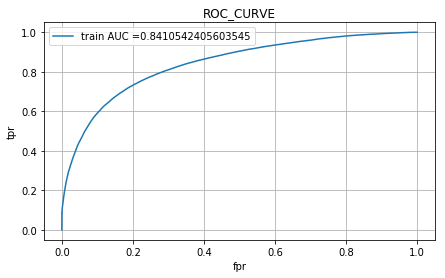

the maximum value of tpr*(1-fpr) 0.5858516757029045 for threshold 0.382


<Figure size 432x288 with 0 Axes>

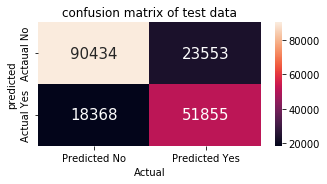

train_auc_score = 0.8410542405603545
--------------------------------------------------------------------------------------------------------------
logloss Train:-- 7.860153510500646
--------------------------------------------------------------------------------------------------------------
F1 Train:-- 0.7121423323330884


In [ ]:
final_test(X,y)

## Deployment on Heroku



1. https://healthcare-fraud-api.herokuapp.com/index 